Repository

https://github.com/Subhashchandrupatla/CNN-Effect-of-Filters-and-Depth

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models
    TF_AVAILABLE = True
    print("Using TensorFlow:", tf.__version__)
except Exception as e:
    TF_AVAILABLE = False
    print("TensorFlow not available. If you want to run this notebook install tensorflow (e.g. pip install tensorflow).")
    print("Error:", e)




Using TensorFlow: 2.19.0


In [2]:

if not TF_AVAILABLE:
    raise RuntimeError("TensorFlow is required for this notebook. Install it and re-run.")

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)
num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat  = keras.utils.to_categorical(y_test, num_classes)

print("Shapes -> x_train:", x_train.shape, "x_test:", x_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shapes -> x_train: (60000, 28, 28, 1) x_test: (10000, 28, 28, 1)


In [3]:

def build_cnn(input_shape=(28,28,1), num_conv_layers=2, base_filters=32, kernel_size=3, dense_units=128):
    """
    Build a sequential CNN:
      - num_conv_layers: how many Conv2D + MaxPool blocks
      - base_filters: number of filters in the first Conv layer (later layers double)
      - kernel_size: size of the conv kernel (3 or 5 for our experiments)
      - dense_units: units in the dense layer
    """
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    for i in range(num_conv_layers):
        filters = base_filters * (2**i) if i>0 else base_filters
        model.add(layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

test_model = build_cnn(num_conv_layers=2, base_filters=16, kernel_size=3)
test_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,922 (808.29 KB)

 Trainable params: 206,922 (808.29 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:

experiments = [
    {"name": "Shallow_k3", "num_conv_layers": 1, "base_filters": 16, "kernel_size": 3},
    {"name": "Deeper_k3",  "num_conv_layers": 3, "base_filters": 16, "kernel_size": 3},
    {"name": "Shallow_k5", "num_conv_layers": 1, "base_filters": 16, "kernel_size": 5},
    {"name": "Deeper_k5",  "num_conv_layers": 3, "base_filters": 16, "kernel_size": 5},
]

histories = {}
results = {}

EPOCHS = 5
BATCH_SIZE = 128

for exp in experiments:
    name = exp["name"]
    print(f"\n--- Training {name}: layers={exp['num_conv_layers']} kernel={exp['kernel_size']}")
    model = build_cnn(num_conv_layers=exp['num_conv_layers'],
                      base_filters=exp['base_filters'],
                      kernel_size=exp['kernel_size'])
    hist = model.fit(x_train, y_train_cat,
                     validation_split=0.1,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     verbose=2)
    loss, acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"{name} test loss: {loss:.4f}, test acc: {acc:.4f}")
    histories[name] = hist
    results[name] = {"model": model, "test_loss": loss, "test_acc": acc}



--- Training Shallow_k3: layers=1 kernel=3
Epoch 1/5
422/422 - 24s - 56ms/step - accuracy: 0.8967 - loss: 0.3509 - val_accuracy: 0.9755 - val_loss: 0.0939
Epoch 2/5
422/422 - 19s - 46ms/step - accuracy: 0.9609 - loss: 0.1327 - val_accuracy: 0.9830 - val_loss: 0.0632
Epoch 3/5
422/422 - 21s - 50ms/step - accuracy: 0.9724 - loss: 0.0936 - val_accuracy: 0.9847 - val_loss: 0.0582
Epoch 4/5
422/422 - 21s - 50ms/step - accuracy: 0.9777 - loss: 0.0747 - val_accuracy: 0.9873 - val_loss: 0.0522
Epoch 5/5
422/422 - 20s - 47ms/step - accuracy: 0.9798 - loss: 0.0636 - val_accuracy: 0.9887 - val_loss: 0.0491
Shallow_k3 test loss: 0.0460, test acc: 0.9842

--- Training Deeper_k3: layers=3 kernel=3
Epoch 1/5
422/422 - 42s - 100ms/step - accuracy: 0.8864 - loss: 0.3663 - val_accuracy: 0.9782 - val_loss: 0.0732
Epoch 2/5
422/422 - 39s - 93ms/step - accuracy: 0.9682 - loss: 0.1052 - val_accuracy: 0.9852 - val_loss: 0.0532
Epoch 3/5
422/422 - 38s - 89ms/step - accuracy: 0.9775 - loss: 0.0744 - val_accur

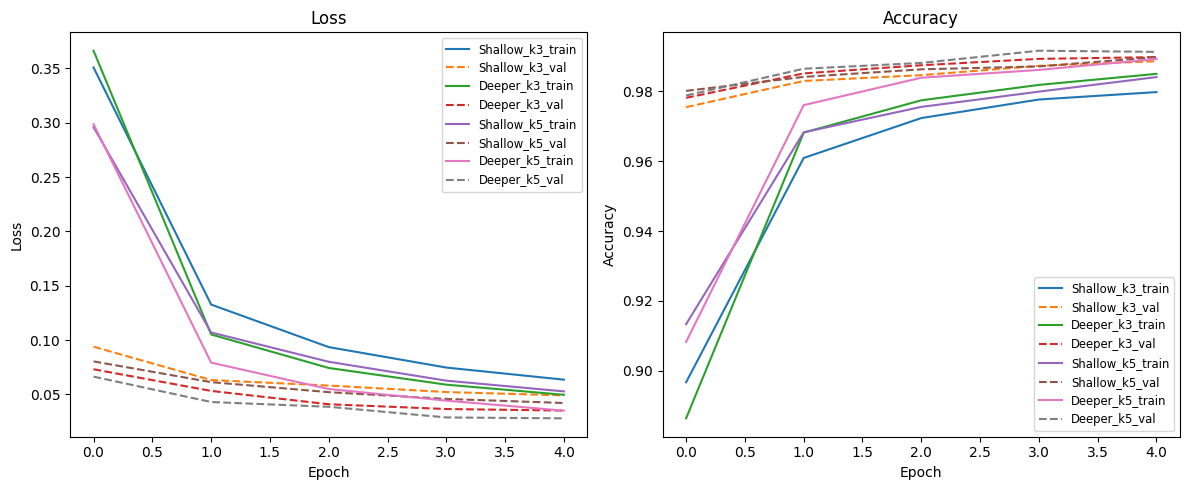

In [5]:

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for name, h in histories.items():
    plt.plot(h.history['loss'], label=f"{name}_train")
    plt.plot(h.history['val_loss'], '--', label=f"{name}_val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize='small')

plt.subplot(1,2,2)
for name, h in histories.items():
    plt.plot(h.history['accuracy'], label=f"{name}_train")
    plt.plot(h.history['val_accuracy'], '--', label=f"{name}_val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(fontsize='small')

plt.tight_layout()
plt.show()


First conv weights shape: (3, 3, 1, 16)


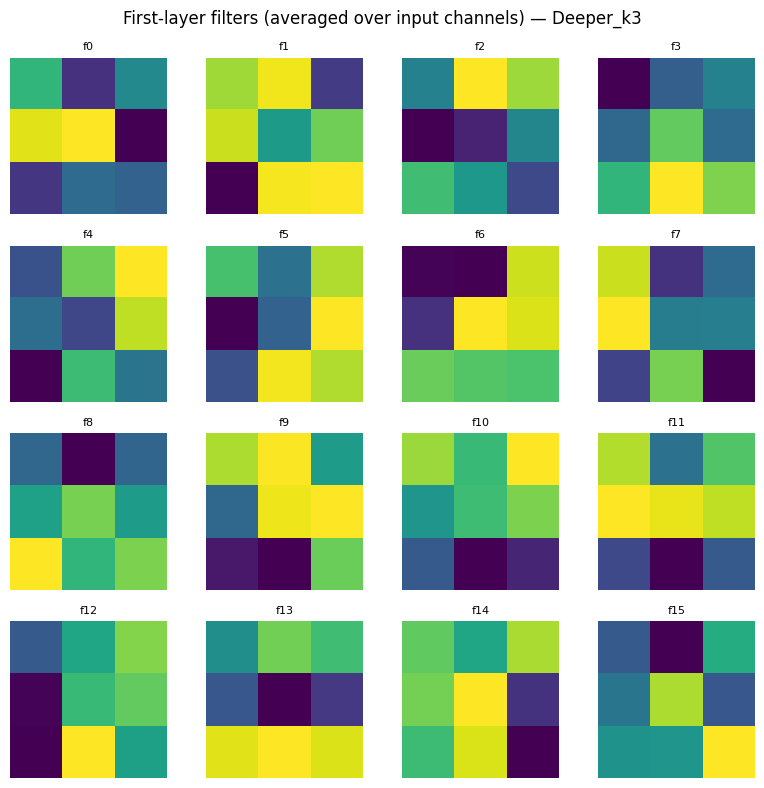

In [6]:


chosen_name = "Deeper_k3"
if chosen_name not in results:
    raise KeyError(f"Model '{chosen_name}' not found in results. Available: {list(results.keys())}")

model = results[chosen_name]["model"]


if not model.built:
    _ = model.predict(x_test[:1])


from tensorflow.keras.layers import Conv2D
first_conv = None
for layer in model.layers:
    if isinstance(layer, Conv2D):
        first_conv = layer
        break

if first_conv is None:

    def find_first_conv(layers_list):
        for l in layers_list:
            if isinstance(l, Conv2D):
                return l

            if hasattr(l, 'layers'):
                found = find_first_conv(l.layers)
                if found is not None:
                    return found
        return None
    first_conv = find_first_conv(model.layers)

if first_conv is None:
    raise RuntimeError("No Conv2D layer found in the model. Make sure the model has Conv2D layers.")

weights = first_conv.get_weights()[0]
print("First conv weights shape:", weights.shape)


def normalize(arr):
    arr = np.array(arr)
    mn, mx = arr.min(), arr.max()
    if mx - mn == 0:
        return np.zeros_like(arr)
    return (arr - mn) / (mx - mn)

kernel_h, kernel_w, in_ch, out_ch = weights.shape
n_filters = min(16, out_ch)

plt.figure(figsize=(8,8))
for i in range(n_filters):
    filt = weights[:, :, :, i]

    if in_ch > 1:
        filt_disp = np.mean(filt, axis=-1)
    else:
        filt_disp = filt.squeeze()
    filt_norm = normalize(filt_disp)
    plt.subplot(4, 4, i+1)
    plt.imshow(filt_norm, aspect='equal')
    plt.axis('off')
    plt.title(f"f{i}", fontsize=8)
plt.suptitle(f"First-layer filters (averaged over input channels) — {chosen_name}")
plt.tight_layout()
plt.show()


First Conv Layer: conv2d_3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Feature map shape: (1, 28, 28, 16)


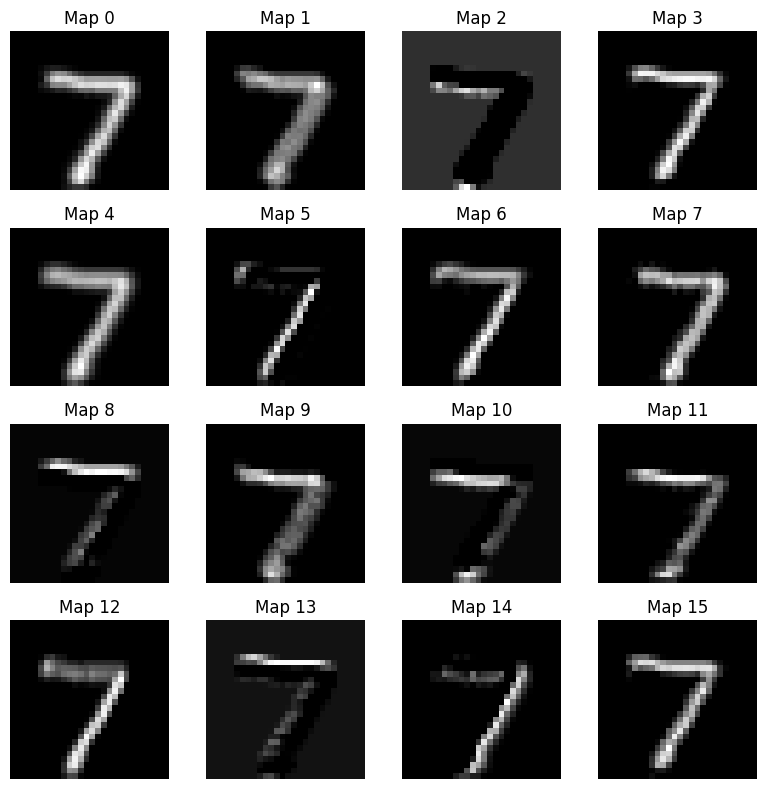

In [7]:


from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Model

chosen_name = "Deeper_k3"
model = results[chosen_name]["model"]


try:
    _ = model(x_test[:1])
except:
    model.build((None, 28, 28, 1))
    _ = model(x_test[:1])


first_conv = None
for layer in model.layers:
    if isinstance(layer, Conv2D):
        first_conv = layer
        break

print("First Conv Layer:", first_conv.name)


intermediate_model = Model(
    inputs=model.layers[0].input,
    outputs=first_conv.output
)


sample = x_test[:1]


fmaps = intermediate_model.predict(sample)
print("Feature map shape:", fmaps.shape)


import numpy as np
import matplotlib.pyplot as plt

num_maps = min(16, fmaps.shape[-1])

plt.figure(figsize=(8, 8))
for i in range(num_maps):
    plt.subplot(4, 4, i+1)
    plt.imshow(fmaps[0, :, :, i], cmap="gray")
    plt.axis("off")
    plt.title(f"Map {i}")

plt.tight_layout()
plt.show()


In [8]:

outdir = "/mnt/data/cnn_demo"
os.makedirs(outdir, exist_ok=True)
print("Experiment results:")
for name, info in results.items():
    print(f"  {name}: test_acc={info['test_acc']:.4f}, test_loss={info['test_loss']:.4f}")
    # Save model
    path = os.path.join(outdir, f"{name}.h5")
    info['model'].save(path)
print(f"\nSaved models to {outdir} (downloadable in many environments).")


Experiment results:
  Shallow_k3: test_acc=0.9842, test_loss=0.0460
  Deeper_k3: test_acc=0.9904, test_loss=0.0283
  Shallow_k5: test_acc=0.9857, test_loss=0.0405
  Deeper_k5: test_acc=0.9922, test_loss=0.0265

Saved models to /mnt/data/cnn_demo (downloadable in many environments).
